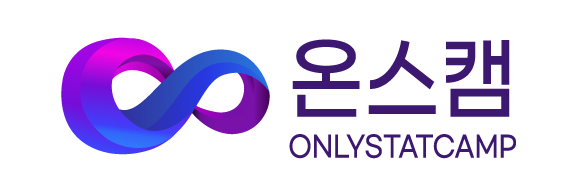

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png?20211003060202" height="100">

In [ ]:
import torch

In [ ]:
torch.__version__

'2.3.0+cu121'

## RNN 기초 맛보기

In [ ]:
import torch.nn as nn
import torch.optim as optim

- [batch사이즈, columns개수]
- [batch사이즈, w, h]
- [batch사이즈, w, h, 3]
- [batch사이즈, seq, columns개수]

In [ ]:
# RNN 모델 정의
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# 데이터 준비 (예: 시퀀스 예측을 위한 임의의 데이터 생성)
input_size = 10
sequence_length = 5

batch_size = 3
output_size = 1
hidden_size = 20

In [ ]:
# 임의의 입력 데이터
x = torch.randn(batch_size, sequence_length, input_size)
y = torch.randn(batch_size, output_size)

In [ ]:
x.shape

torch.Size([3, 5, 10])

In [ ]:
y.shape

torch.Size([3, 1])

In [ ]:
# 모델, 손실 함수, 최적화기 정의
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 학습 과정
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    outputs = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 모델 평가 (예: 예측)
model.eval()
with torch.no_grad():
    test_input = torch.randn(batch_size, sequence_length, input_size)
    test_output = model(test_input)
    print(f'Predicted output: {test_output}')

Predicted output: tensor([[ 0.0298],
        [-0.2721],
        [-0.2448]])


---

## 삼성전자 주가 예측해보기

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/content/A005930.csv", encoding='cp949')

In [ ]:
data

,날짜,시간,시가,고가,저가,종가,전일대비,거래량
0,19800104,0,42,43,41,41,13,528022
1,19800105,0,40,42,40,42,1,1580051
2,19800107,0,43,44,43,44,2,2425288
3,19800108,0,47,47,45,47,2,5396669
4,19800109,0,47,49,46,49,2,4993123
...,...,...,...,...,...,...,...,...
11834,20240527,0,75300,78200,74000,77200,1300,43825202
11835,20240528,0,76500,78000,76200,77600,400,18539072
11836,20240529,0,77700,78200,75200,75200,-2400,30244875
11837,20240530,0,74800,75200,73500,73500,-1700,28551273


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# 필요한 데이터 추출 및 전처리
data = data[['날짜', '종가']]
data['날짜'] = pd.to_datetime(data['날짜'], format='%Y%m%d')
data.set_index('날짜', inplace=True)

<ipython-input-19-733c06232995>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['날짜'] = pd.to_datetime(data['날짜'], format='%Y%m%d')


In [ ]:
train_data = data[data.index < '2024-01-01']
test_data = data[data.index >= '2024-01-01']

In [ ]:
# 종가 데이터 정규화
scaler = MinMaxScaler()
train_data['종가'] = scaler.fit_transform(train_data[['종가']])
test_data['종가'] = scaler.transform(test_data[['종가']])

<ipython-input-21-1884c12f52f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['종가'] = scaler.fit_transform(train_data[['종가']])
<ipython-input-21-1884c12f52f5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['종가'] = scaler.transform(test_data[['종가']])


In [ ]:
train_data

,종가
날짜,
1980-01-04,0.000099
1980-01-05,0.000110
1980-01-07,0.000132
1980-01-08,0.000165
1980-01-09,0.000187
...,...
2023-12-21,0.824114
2023-12-22,0.834008
2023-12-26,0.841703


In [ ]:
test_data

,종가
날짜,
2024-01-02,0.874681
2024-01-03,0.846100
2024-01-04,0.841703
2024-01-05,0.841703
2024-01-08,0.840603
...,...
2024-05-27,0.848298
2024-05-28,0.852695
2024-05-29,0.826313


In [ ]:
# 시퀀스 데이터 생성
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)


In [ ]:
sequence_length = 60
X_train, y_train = create_sequences(train_data['종가'].values, sequence_length)
X_test, y_test = create_sequences(test_data['종가'].values, sequence_length)

In [ ]:
X_train.shape

(11677, 60)

In [ ]:
y_train.shape

(11677,)

In [ ]:
X_test.shape

(42, 60)

In [ ]:
y_test.shape

(42,)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

In [ ]:
# RNN 모델 정의
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size = 1
hidden_size = 20
output_size = 1

In [ ]:
model = StockPriceRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [20/100], Loss: 0.0401
Epoch [40/100], Loss: 0.0173
Epoch [60/100], Loss: 0.0023
Epoch [80/100], Loss: 0.0007
Epoch [100/100], Loss: 0.0005


In [ ]:
# 모델 평가 및 예측
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

    # 예측값과 실제값 비교
    test_output = test_output.numpy()
    y_test = y_test.numpy()
    test_output = scaler.inverse_transform(test_output)
    y_test = scaler.inverse_transform(y_test)

Test Loss: 0.0102


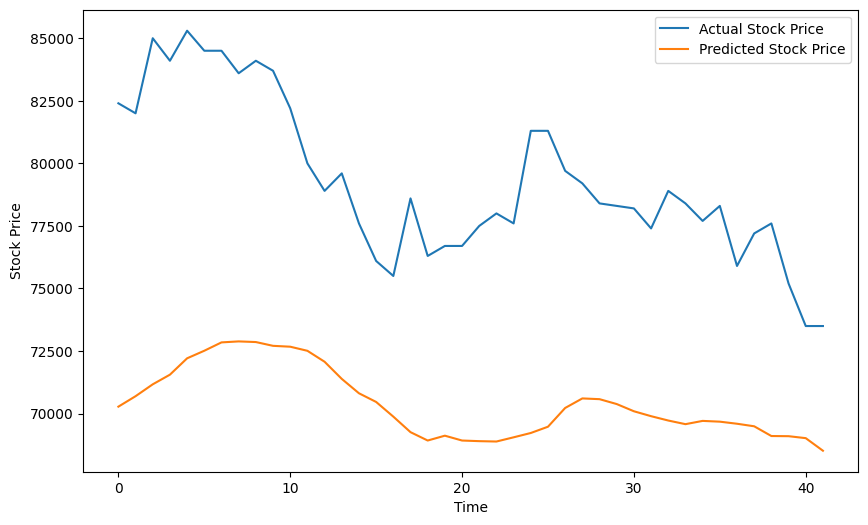

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(test_output, label='Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

---

Transformer